# [LAB 05] 비지도 학습 PBT
## 구매 패턴 기반 고객 군집 분석과 페르소나 도출

우리는 흔히 이렇게 말합니다.

> “도매 고객은 다 비슷하지 않나요?”  
> “어차피 대량으로 사는 사람들 아닌가요?”

하지만 정말 그럴까요?

신선식품을 중심으로 꾸준히 구매하는 고객과  
세제·종이류를 한 번에 대량 구매하는 고객은  
같은 방식으로 관리해도 되는 고객일까요?

이번 프로젝트에서는 **도매 유통 고객의 카테고리별 구매 데이터**를 활용하여  
겉보기에는 비슷해 보이는 고객들 사이에  
실제로 어떤 **구매 패턴 차이**가 존재하는지를  
데이터 기반으로 하나씩 확인해봅니다.

이 과제의 목표는 군집 알고리즘을 많이 적용하는 것이 아니라,

> **“이 고객들은 어떤 기준에서 서로 다른 사람들인가?”**  
> **“이 차이를 어떻게 설명하고, 어떻게 관리할 수 있을까?”**

를 **수치와 언어로 설명하는 것**입니다.


### 라이브러리 참조

In [102]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
import pingouin as pg
from pandas import DataFrame, get_dummies
# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statannotations.Annotator import Annotator

# 로지스틱을 위한 참조
import statsmodels.api as sm

from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from sklearn.preprocessing import RobustScaler

# 로지스틱 결과 판별을 위한 참조
# → 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr


from scipy.spatial import ConvexHull
from sklearn.preprocessing import MinMaxScaler , StandardScaler


from sklearn.decomposition import PCA



# 클러스터링 관련 참조
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial import ConvexHull


#Elbow Point 계산 라이브러리
from kneed import KneeLocator

#정규성 검정 라이브러리
from scipy.stats import normaltest

#데이터 전처리 라이브러리
from sklearn.preprocessing import StandardScaler,OneHotEncoder

#실루엣 스코어 라이브러리
from sklearn.metrics import silhouette_samples,silhouette_score
my_dpi = 200


from hossam import load_data, my_dpi
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from scipy.spatial import ConvexHull

from kneed import KneeLocator

#성능평가지표
from sklearn.metrics import adjusted_rand_score




### 데이터 불러오기

In [103]:
from hossam import *

origin = hs_util.load_data('wholesale_customers')
df = origin.drop(['Channel','Region'] , axis=1)

df.head()

이 데이터 세트는 도매 유통업체의 고객 정보를 담고 있습니다. 다양한 제품 카테고리에 대한 연간 지출액(mu, 화폐 단위)을 포함합니다. (출처: https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)

컬럼명            의미                  설명
----------------  --------------------  --------------------------------------------------------------------------------------------
Channel           유통 채널             고객의 거래 채널을 나타냄. 주로 Horeca(호텔·레스토랑·카페) 또는 Retail(소매점) 구분에 사용됨
Region            지역                  고객이 속한 지리적 지역 구분 변수. 특정 국가 내의 권역 정보
Fresh             신선식품 구매액       육류, 채소, 과일 등 신선식품 카테고리에 대한 연간 구매 금액
Milk              유제품 구매액         우유, 치즈, 요거트 등 유제품 카테고리에 대한 연간 구매 금액
Grocery           식료품 구매액         가공식품, 일반 식료품 등 장기 보관 식품 카테고리 구매 금액
Frozen            냉동식품 구매액       냉동 육류, 냉동 가공식품 등 냉동식품 카테고리 구매 금액
Detergents_Paper  세제·종이류 구매액    세제, 화장지, 키친타월 등 생활 소모품 구매 금액
Delicassen        즉석·가공식품 구매액  즉석식품, 델리 식품, 가공 반찬류 등의 구매 금액


✅ 테이블 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 column

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### 데이터 설명

`wholesale_customers` 데이터셋은 회원제 도매 유통 고객의 **연간 카테고리별 구매 금액**을 정리한 데이터입니다.

각 행은 고객 1명을 의미하며, 다음과 같은 컬럼으로 구성되어 있습니다.

| 컬럼명 | 의미 |
|--------|------|
| Channel | 고객의 거래 채널 (Horeca / Retail) |
| Region | 고객이 속한 지역 |
| Fresh | 신선식품 구매액 |
| Milk | 유제품 구매액 |
| Grocery | 일반식료품 구매액 |
| Frozen | 냉동식품 구매액 |
| Detergents_Paper | 세제·종이류 구매액 |
| Delicassen | 즉석·가공식품 구매액 |

본 프로젝트에서는 **Fresh부터 Delicassen까지의 구매 금액 변수들**을 사용하여 군집 분석을 수행합니다.  
`Channel`과 `Region`은 해석을 보조하는 **참고 정보**로 활용합니다.


In [104]:
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## 미션 1. 이 고객 데이터는 정말 하나의 집단일까?

먼저 데이터를 있는 그대로 살펴보십시오.

각 구매 금액 변수의 분포를 히스토그램과 박스플롯으로 확인하고,
고객들이 얼마나 다양한 구매 규모를 보이는지 관찰하십시오.

이 단계에서는 어떠한 군집 알고리즘도 사용하지 않습니다.
데이터가 주는 첫인상을 정리하는 데 집중해 주세요.

📌 출제 의도
군집 분석은 “나누고 싶다”는 목적에서 시작되지 않습니다.
이 미션은 이 데이터가 정말로 나눌 만한 차이를 가지고 있는지를
학생 스스로 발견하도록 하기 위한 단계입니다.


<데이터 파악>
1. describe 를 통한 데이터 첫 인상 파악
- 모든 변수 전반적으로 mix  와 max 차이가 큼 
- 표준 편차가 모두 평균보다 큼 , 데이터 간 격차가 큼
- 모든 변수의 중앙값보다 평균이 더 우측에 위치하여, 우측으로 긴 꼬리가 있는 분포 양상임을 추측할 수 있음


2. Hist plot 기반의 파악
- 모든 변수에서 우측의 긴 꼬리 확인

3. Box plot 기반의 파악
- 모든 변수에서 100000 이상의 이상치 확인,
- 그 외에도 IQR 을 넘는 이상치 모든 변수에서 확인되었음

In [105]:
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [106]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


#### Hist plot

In [ ]:
df_plot=df.copy()

# 1) 그래프 초기화
width_px = 4000
height_px = 1000
rows, cols = 1, 6
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

cols_list = ['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen']

# 2) 히스토그램 + KDE
for i, col in enumerate(cols_list):
    sb.histplot(
        data=df_plot,
        x=col,
        bins=50,
        kde=True,
        ax=ax[i]
    )
    ax[i].set_title(col, fontsize=14, fontweight='bold')
    ax[i].grid(axis='y', linestyle='--', alpha=0.6)

# 3) 출력
plt.tight_layout()
plt.show()
plt.close()


#### Box plot

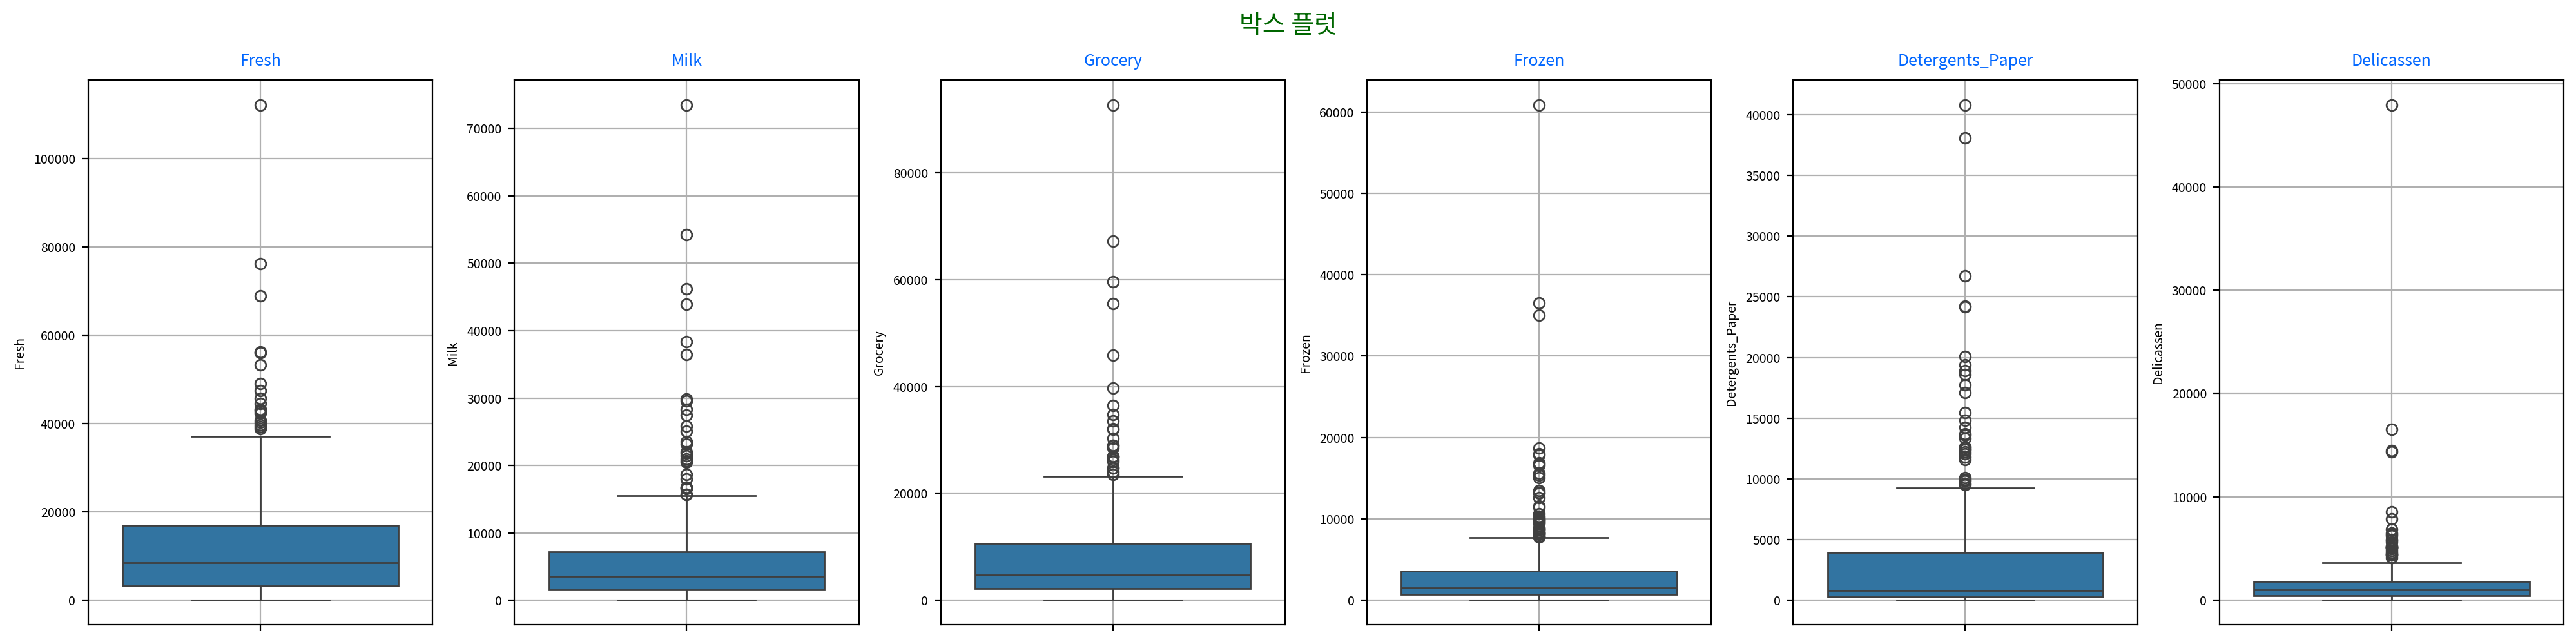

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 4000        # 가로 크기 늘림
height_px = 1000              # 세로 크기 줄임 (1행)
rows = 1
cols = 6
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)


# 2) boxplot 그리기
sb.boxplot(data=df_plot, y='Fresh', ax=ax[0])
sb.boxplot(data=df_plot, y='Milk', ax=ax[1])  
sb.boxplot(data=df_plot, y='Grocery', ax=ax[2])
sb.boxplot(data=df_plot, y='Frozen', ax=ax[3])
sb.boxplot(data=df_plot, y='Detergents_Paper', ax=ax[4])  
sb.boxplot(data=df_plot, y='Delicassen', ax=ax[5])

# 3) 그래프 꾸미기
fig.suptitle('박스 플럿', fontsize=14, color='#006600')

fig.subplots_adjust(wspace=0.3)

titles = ['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen']

for i in range(6):
    ax[i].set_title(titles[i], color="#0066ff", fontsize=9, pad=8)
    ax[i].grid()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


## 미션 2. 이대로 거리 계산을 해도 괜찮을까?

구매 금액 변수들 간의 상관관계를 확인하고,
각 변수의 분포 왜도를 점검하십시오.

필요하다고 판단된다면 로그 변환을 적용하고,
표준화가 왜 필요한지 본인의 언어로 설명해 주세요.

전처리 과정에서는 무엇을 했는지보다
왜 그렇게 판단했는지를 서술하는 것이 중요합니다.

📌 출제 의도

군집 분석은 거리 기반 분석입니다.
이 미션은 전처리가 형식적인 절차가 아니라
군집 결과를 바꿀 수 있는 중요한 판단임을 이해시키기 위한 단계입니다.

1. 구매 금액 변수들 간의 상관관계 확인
   
|               | Fresh | Milk | Grocery | Frozen | Detergents_Paper | Delicassen |
|---------------|------|------|---------|--------|------------------|------------|
| **Fresh**     | 1.000 | -0.084 | -0.120 | 0.384 | -0.198 | 0.238 |
| **Milk**      | -0.084 | 1.000 | 0.773 | -0.093 | 0.680 | 0.373 |
| **Grocery**   | -0.120 | 0.773 | 1.000 | -0.169 | 0.801 | 0.304 |
| **Frozen**    | 0.384 | -0.093 | -0.169 | 1.000 | -0.207 | 0.233 |
| **Detergents_Paper** | -0.198 | 0.680 | 0.801 | -0.207 | 1.000 | 0.183 |
| **Delicassen**| 0.238 | 0.373 | 0.304 | 0.233 | 0.183 | 1.000 |



2. 로그변환 적용
- 앞서 미션 1을 통해 모든 구매 금액 변수들이 우측으로 긴 꼬리 형태의 데이터를 보이는 것을 확인하였고, 이에 로그 변환을 함
- 로그 변환을 통해 큰 값은 압축하고, 작은 값은 상태적 차이를 강조하면서 분포를 더 대칭에 가깝게 만들어줌
- 즉, 분포 모양을 정상적인 거리 계산이 가능하게 바꿔주는 작업
- 로그변환 후 전반적으로 비대칭성이 완화된 것 확인 완료


3. 표준화의 필요성
- 앞서 미션 1을 통해 상관계수를 확인하면서 z score 기준의 이상치를 확인한 결과, 모든 구매 금액 변수에서 |z|>3 으로 불균형이 크게 확인된 바있음
- 또, 평균 금액이 1500-12000 으로 단위 차이가 큰 것을 확인했음
- 이때 군집 알고리즘은 거리를 기준으로 판단하기 때문에, 변수 값의 차이 크기가 거리 계산에 들어감
- 만약 스케일링을 하지 않게 되면, 스케일이 큰 변수가 군집의 기준이 되면서 작은 변수는 군집 형성에 영향력이 떨어지게 됨
- 따라서 모든 변수가 평균 0 , 표준편차 1 로 통일되면서, '1단위의 차이' 가 동일한 의미를 가지게 됨
- 이에 데이터 스케일링으로 모든 변수가 유사한 기준에서 거리 계산에 기여하도록 할 필요가 있음

#### 1. 구매 금액 변수들 간의 상관관계 확인

🟦 Milk – Grocery – Detergents_Paper 강한 양의 상관
| 변수 쌍                       | 상관계수              |
| -------------------------- | ----------------- |
| Grocery ↔ Detergents_Paper | **0.801** (매우 강함) |
| Milk ↔ Grocery             | **0.773** (매우 강함) |
| Milk ↔ Detergents_Paper    | **0.680** (강함)    |


3️⃣ 두 그룹은 서로 반대 경향
| 변수     | Grocery 그룹과의 상관       |
| ------ | --------------------- |
| Fresh  | 음의 상관 (-0.12 ~ -0.20) |
| Frozen | 음의 상관 (-0.17 ~ -0.21) |


In [ ]:
df_corr=df_plot.copy()

- 이상치와 왜도 점검

In [ ]:
# 이상치와 왜도 검정
data = df_corr[['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
Fresh,2.561323,-1.707427,7,True
Milk,4.053755,-0.777474,9,True
Grocery,3.587429,-0.83736,7,True
Frozen,5.907986,-0.743309,6,True
Detergents_Paper,3.631851,-0.321751,10,True
Delicassen,11.151586,-1.298797,4,True


이상치가 발견되어 스피어만 상관계수 사용


- Pearson 상관계수
    - 선형 관계 + 정규성 가정 필요
    - 이상치(outlier)에  민감

- Spearman 상관계수
    - 순위 기반 상관
    - 비선형 관계와 이상치에 강건(robust)

본 데이터는극단적으로 큰 값이 존재하는 long-tail 분포
정규성 가정을 충족하지 않음

따라서 Pearson보다 Spearman 상관계수가 더 적합하며,
실제 변수 간 관계를 왜곡 없이 반영할 수 있다.

> 결론: Spearman 상관계수를 기준으로 해석이 적합하다고 판단

In [ ]:
cols = ['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen']

# 스피어만 상관행렬 + p-value 행렬
corr, pvals = spearmanr(df_corr[cols])

# DataFrame으로 정리
spearman_corr = pd.DataFrame(corr, index=cols, columns=cols)
spearman_pval = pd.DataFrame(pvals, index=cols, columns=cols)

spearman_corr, spearman_pval


(                     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
 Fresh             1.000000 -0.083921 -0.119983  0.384395         -0.198333   
 Milk             -0.083921  1.000000  0.773049 -0.092971          0.679979   
 Grocery          -0.119983  0.773049  1.000000 -0.168831          0.801282   
 Frozen            0.384395 -0.092971 -0.168831  1.000000         -0.207183   
 Detergents_Paper -0.198333  0.679979  0.801282 -0.207183          1.000000   
 Delicassen        0.238400  0.372771  0.304256  0.233024          0.183314   
 
                   Delicassen  
 Fresh               0.238400  
 Milk                0.372771  
 Grocery             0.304256  
 Frozen              0.233024  
 Detergents_Paper    0.183314  
 Delicassen          1.000000  ,
                          Fresh          Milk        Grocery        Frozen  \
 Fresh             0.000000e+00  7.867368e-02   1.177758e-02  6.078309e-17   
 Milk              7.867368e-02  0.000000e+00   1.291923e-88  5.

In [ ]:
# 사용할 변수
cols = ['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen']

# 상관계수 선택 (이전에 이상치/왜도 검사 결과 → Spearman 권장)
chosen = 'spearman'   # 또는 'pearson'

corr_matrix = df_corr[cols].corr(method=chosen)
corr_matrix


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,-0.083921,-0.119983,0.384395,-0.198333,0.238400
Milk,-0.083921,1.000000,0.773049,-0.092971,0.679979,0.372771
Grocery,-0.119983,0.773049,1.000000,-0.168831,0.801282,0.304256
Frozen,0.384395,-0.092971,-0.168831,1.000000,-0.207183,0.233024
Detergents_Paper,-0.198333,0.679979,0.801282,-0.207183,1.000000,0.183314
Delicassen,0.238400,0.372771,0.304256,0.233024,0.183314,1.000000


### 상관분석 pvalue 확인 작업 필요

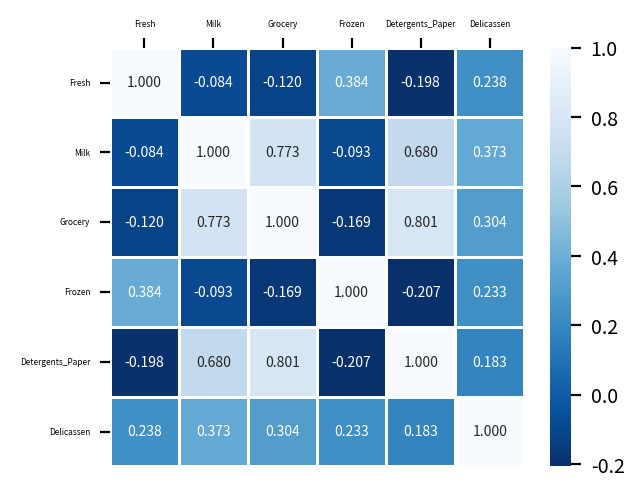

In [ ]:
# 1) 그래프 초기화
width_px  = 650          # 그래프 가로 크기
height_px = 500          # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidth=0.5,
    cmap="Blues_r",
    annot_kws={"size": 5}
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()      # x축의 변수 이름을 상단으로 이동


# 축 글씨 크기 줄이기
ax.tick_params(axis='x', labelsize=3)
ax.tick_params(axis='y', labelsize=3)

# 4) 출력
plt.tight_layout()       # 여백 제거
plt.show()               # 그래프 화면 출력
plt.close()              # 그래프 작업 종료


#### 2. 로그 변환 적용 

In [ ]:
df_log = df_corr.copy()

cols = ['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen']

# 원본 유지 + 로그 변환 컬럼 생성
for i in cols:
  df_log[f'log_{i}'] = np.log1p(df_log[i])


df_log.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,log_Fresh,log_Milk,log_Grocery,log_Frozen,log_Detergents_Paper,log_Delicassen
0,12669,9656,7561,214,2674,1338,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,7057,9810,9568,1762,3293,1776,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682
2,6353,8808,7684,2405,3516,7844,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632
3,13265,1196,4221,6404,507,1788,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412
4,22615,5410,7198,3915,1777,5185,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718


- 로그 변환 후의 분포 비교
> 전반적으로 비대칭성이 완화되었음

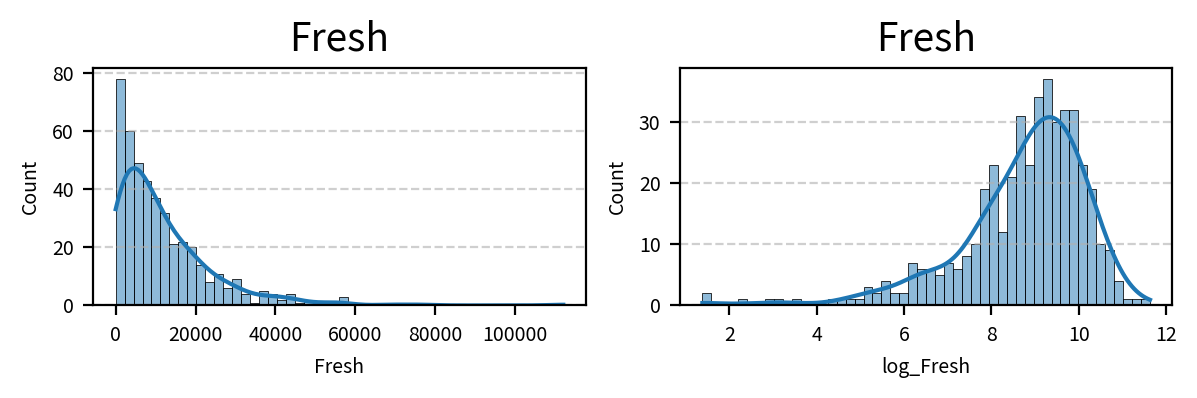

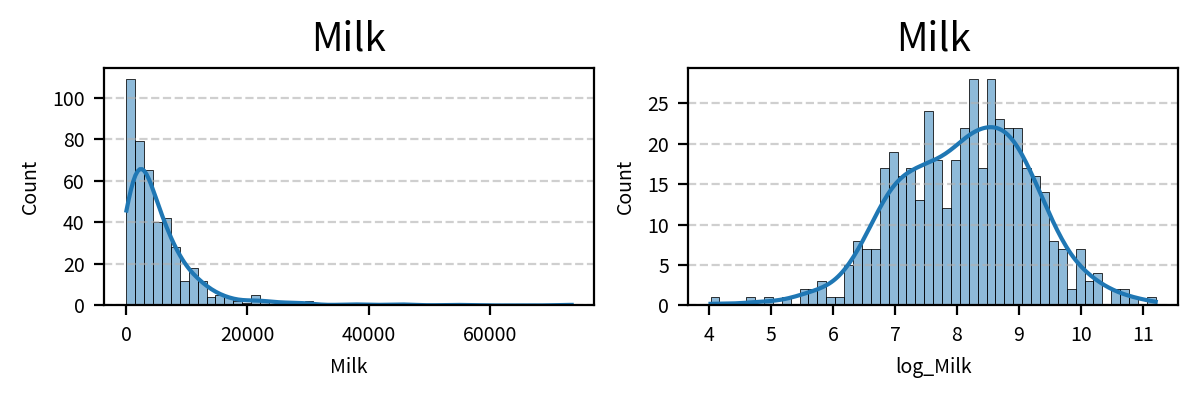

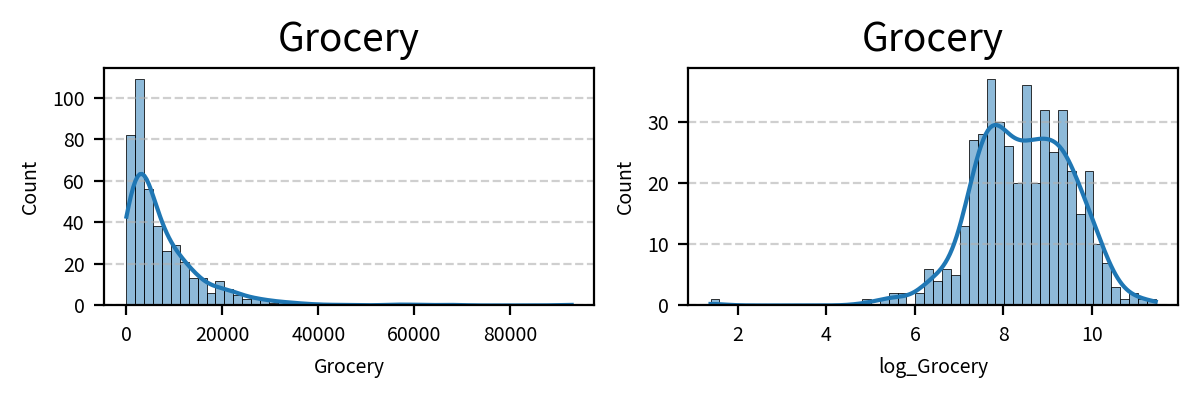

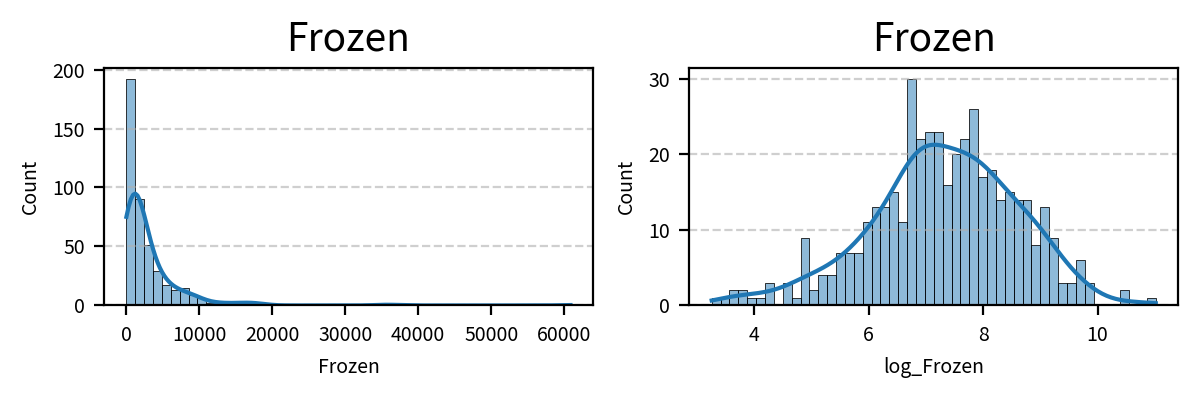

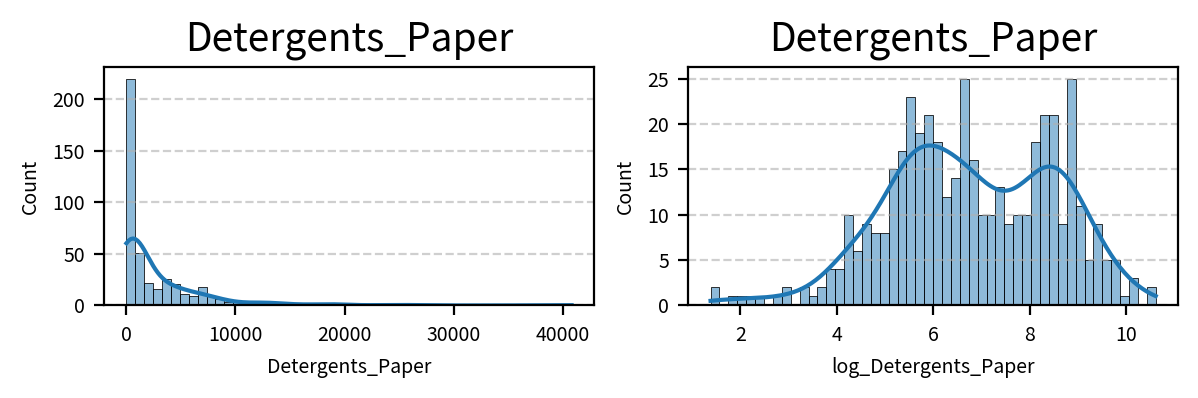

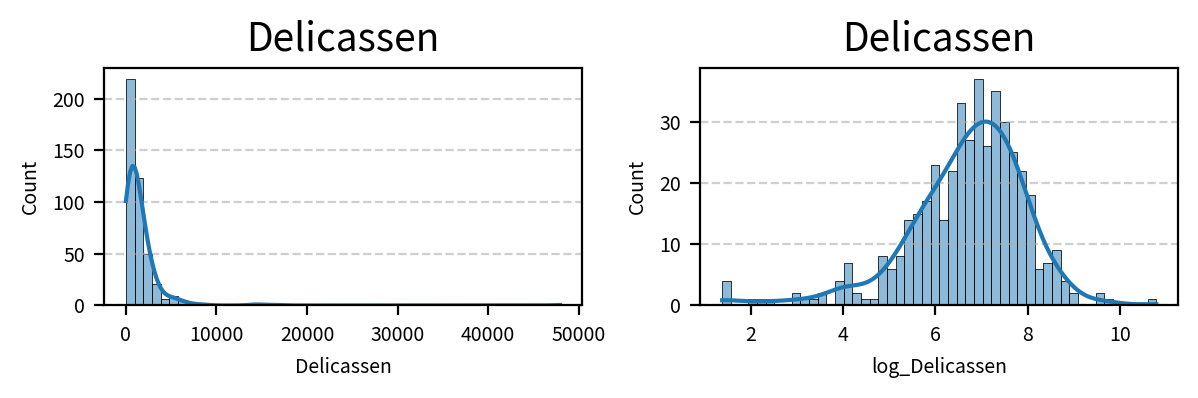

In [ ]:

columns = ['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen']

for i in columns:

  # 1) 그래프 초기화
  width_px = 1200
  height_px = 400
  rows, cols = 1, 2
  figsize = (width_px / my_dpi, height_px / my_dpi)

  fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

  # 2) 원본 charges
  sb.histplot(
      data=df_log,
      x=i,
      bins=50,
      kde=True,
      ax=ax[0]
  )
  ax[0].set_title(f'{i}', fontsize=14, fontweight='bold')
  ax[0].grid(axis='y', linestyle='--', alpha=0.6)

  # 3) 로그 변환 charges
  sb.histplot(
      data=df_log,
      x=f'log_{i}',
      bins=50,
      kde=True,
      ax=ax[1]
  )
  ax[1].set_title(f'{i}', fontsize=14, fontweight='bold')
  ax[1].grid(axis='y', linestyle='--', alpha=0.6)

  # 4) 출력
  plt.tight_layout()
  plt.show()
  plt.close()



#### 3. 표준화, 데이터 스케일링의 필요성

- 앞서 상관계수를 확인하면서 z score 기준의 이상치를 확인한 결과, 모든 구매 금액 변수에서 |z|>3 으로 불균형이 크게 확인된 바있음
- 또, 평균 금액이 1500-12000 으로 단위 차이가 큰 것을 확인했음
- 이때 군집 알고리즘은 거리를 기준으로 판단하기 때문에, 변수 값의 차이 크기가 거리 계산에 들어감
- 만약 스케일링을 하지 않게 되면, 스케일이 큰 변수가 군집의 기준이 되면서 작은 변수는 군집 형성에 영향력이 떨어지게 됨
- 따라서 모든 변수가 평균 0 , 표준편차 1 로 통일되면서, '1단위의 차이' 가 동일한 의미를 가지게 됨
- 이에 데이터 스케일링으로 모든 변수가 유사한 기준에서 거리 계산에 기여하도록 할 필요가 있음

In [ ]:
scaler = StandardScaler()
sdf = DataFrame (scaler.fit_transform(df_log),columns=df_log.columns)
sdf

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,log_Fresh,log_Milk,log_Grocery,log_Frozen,log_Detergents_Paper,log_Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,0.486184,0.976299,0.440155,-1.509250,0.644143,0.408966
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,0.087889,0.990956,0.652171,0.134052,0.766043,0.627926
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,0.016356,0.891151,0.454687,0.376899,0.804405,1.776833
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,0.517477,-0.957973,-0.084792,1.141574,-0.328712,0.633133
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,0.880631,0.439662,0.395847,0.757322,0.404939,1.456588
...,...,...,...,...,...,...,...,...,...,...,...,...
435,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091,1.066222,1.181548,1.116754,1.702540,-0.926632,0.794891
436,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501,1.255565,-0.791906,-1.623340,0.867791,-1.316771,0.843179
437,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456,0.579528,1.413991,1.688657,-0.953514,1.647619,0.666566
438,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046,0.344609,-0.490783,-0.658498,-0.278901,-0.973241,0.766663


In [ ]:
sdf = df.drop(columns=['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicassen'])


## 미션 3. 이 고객들은 어떤 축에서 갈라질까? (PCA)

전처리된 데이터를 기반으로 누적 설명분산비가 80% 이상이 되도록 데이터를 요약하십시오.
선택된 주성분의 개수와 주성분의 설명분산비를 제시하고, 이 결과가 의미하는 바를 간단히 설명하십시오.

먼저, 선택한 주성분의 설명분산비와 누적 설명분산비를 표나 그래프로 제시하십시오. 이를 통해, 원래의 구매 정보 중 어느 정도가 몇 개의 주성분으로 요약되었는지 명확히 드러내야 합니다.

다음으로, 선택된 주성분 중 앞의 두 개를 사용하여 산점도를 시각화하십시오. 이 시각화는 이후 군집 분석의 기준 좌표로 활용될 수 있어야 합니다.

마지막으로, 각 주성분이 어떤 구매 패턴의 차이를 요약하고 있는지 **변수 기여도(loading)**를 참고하여 의미를 문장으로 설명하십시오. 이때 단순히 수치를 나열하지 말고,
**“어떤 고객들이 이 축을 따라 서로 달라지는가”**라는 관점에서 해석해 주시기 바랍니다.

또한, 80% 설명분산 기준을 사용했을 때의 장점과 한계를 조사하여 간단히 제시하십시오.

📌 출제 의도

이 미션의 목적은 PCA를 시각화 도구로 사용하는 것이 아니라, 정보 손실을 통제하면서 데이터 구조를 요약하는 사고 과정을 훈련하는 데 있습니다.
설명분산을 먼저 확인하고, 그 결과를 시각화 해석으로 연결하는 논리적 분석 흐름을 만드는 것이 핵심입니다.

1️⃣ 주성분 개수 선정 및 설명분산비

누적 설명분산비가 80% 이상이 되도록 PCA를 수행한 결과, 총 4개의 주성분(PC1~PC4) 이 선택되었다.

| 주성분 | 설명분산비 | 누적 설명분산비  |
| --- | ----- | --------- |
| PC1 | 0.392 | 0.392     |
| PC2 | 0.240 | 0.632     |
| PC3 | 0.093 | 0.725     |
| PC4 | 0.076 | **0.801** |

> PC1~PC4 네 개의 축만으로도 원래 고차원 구매 데이터의 약 80% 분산(정보량) 을 보존할 수 있다.

2️⃣ PC1–PC2 산점도 시각화
PC1과 PC2를 기준으로 고객을 시각화하면, 고객들이 단일 집단이 아니라 여러 방향으로 분포하고 있음을 확인할 수 있다.
이는 고객 구매 행동이 하나의 기준이 아니라, 여러 소비 성향 축에 따라 달라진다는 것을 시사한다.
이 두 축은 이후 군집 분석(K-means 등)에서 고객을 구분하는 기준 좌표로 활용될 수 있다.


3️⃣ 주성분 해석 (변수 기여도 기반)
주성분의 로딩(loading)을 기반으로 각 축이 의미하는 소비 패턴을 해석하면 다음과 같다.
🥇 PC1: 대량 구매 vs 소량 구매 성향 축
PC1에는 여러 상품군이 전반적으로 양(+)의 가중치를 보이며 함께 증가하는 경향이 있다.
이는 특정 품목만이 아니라 전반적인 구매 규모가 큰 고객과 작은 고객을 구분하는 축으로 해석할 수 있다.

👉 PC1이 높은 고객

다양한 카테고리에서 전반적으로 구매량이 많음
도매형/대량 구매 성향 고객

👉 PC1이 낮은 고객
전반적인 구매량이 적은 소규모 소비 고객
🥈 PC2: 신선식품 중심 vs 가공식품 중심 소비 축

PC2에서는 일부 품목은 양(+)의 가중치, 다른 품목은 음(−)의 가중치를 보이며 대비 구조를 형성한다.
특히 신선식품 계열과 가공·생활용품 계열 간의 소비 차이가 반영된 축으로 해석된다.

👉 PC2가 높은 고객
신선식품 위주의 구매 패턴, 식자재 중심 소비

👉 PC2가 낮은 고객
가공식품/생활용품 중심 구매 , 편의 중심 소비 패턴

즉, PC2는 단순한 구매량 차이가 아니라 “무엇을 주로 사느냐”의 차이를 보여주는 축이다.

🥉 PC3, PC4: 세부적인 소비 스타일 차이
PC3와 PC4는 설명력이 비교적 낮지만(약 9%, 7%),
특정 소수 품목에서 두드러진 가중치를 보이며 세부적인 소비 유형 차이를 설명하는 역할을 한다.

이 축들은 주요 구조를 설명하는 PC1, PC2를 보완하는 보조적 차원으로 볼 수 있다.


4️⃣ 80% 설명분산 기준의 장점과 한계
✅ 장점
정보 손실을 통제하면서 차원을 줄일 수 있음
노이즈나 미세한 변동을 제거하고 핵심 패턴 중심 분석 가능
이후 군집 분석, 시각화, 모델링의 계산 효율 향상

⚠️ 한계
남은 20% 정보에는 특정 소수 고객의 독특한 소비 패턴이 포함될 수 있음
PCA 축은 해석 가능한 “실제 변수”가 아니라 선형 결합된 인공 축이므로 직관적 해석이 어려울 수 있음
설명분산 기준은 통계적 기준일 뿐, 비즈니스적으로 중요한 정보 손실 여부는 별도 판단 필요

#### 차원 축소 수행

In [ ]:
estimator = PCA(n_components=0.8 , random_state=52)
pca = estimator.fit_transform(sdf)

n=pca.shape[1]
cols = [f'PC{i+1}' for i in range(n)]


pca_df = DataFrame(pca , columns=cols)
pca_df

ValueError: at least one array or dtype is required

- 주성분의 설명 분산비 (설명력)

In [ ]:
estimator.explained_variance_ratio_

array([0.39185602, 0.23959118, 0.09298715, 0.07606322])

- 주성분 로딩 벡터

In [ ]:
estimator.components_

array([[-0.01105455,  0.38100493,  0.41739328, -0.00734129,  0.39543308,
         0.15349181, -0.04971043,  0.3932012 ,  0.40818296, -0.0682533 ,
         0.3834196 ,  0.15860074],
       [ 0.42654752,  0.11649266, -0.03777494,  0.43374574, -0.10780057,
         0.34519058,  0.40694953,  0.06371155, -0.03493105,  0.4405815 ,
        -0.11292821,  0.3261821 ],
       [ 0.5305783 , -0.02783911,  0.10234365, -0.33465335,  0.14230418,
        -0.38997179,  0.58097373, -0.03380244,  0.0232136 , -0.18045085,
         0.07578214, -0.21306969],
       [ 0.04361443, -0.06099333, -0.1516081 , -0.46957816, -0.18926463,
         0.41238201,  0.10314721,  0.03596698, -0.03066211, -0.47266795,
        -0.05566126,  0.55283144]])

- bi plot

C:\Users\itwill\AppData\Local\Temp\ipykernel_27140\719931655.py:43: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(


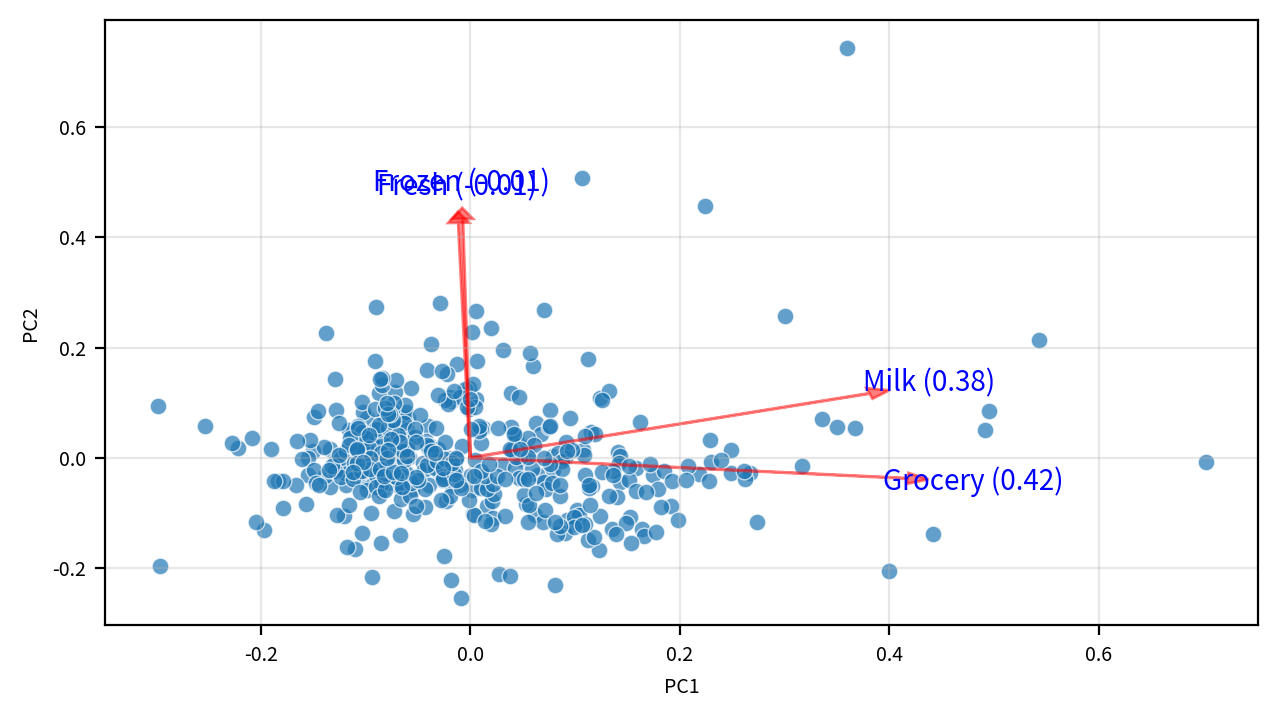

In [ ]:

#어떤 두 개의 주성분 축을 볼지 선택
#PCA 가 새로 만든 좌표계 중 가장 중요한 축 2개를 기준으로 시각화 하겠다는 뜻

xname = "PC1"
yname = "PC2"

#PCA 모델 객체 / transform 을 통해서 원본 데이터 sdf 를 PCA 좌표 공간으로 이동
#즉 여기서 SCORE 는 각 샘플의 PCA 좌표 (여기서 새로운 좌표계로 이동한거 , 기저 변환)
score = estimator.transform(sdf)    


#이 줄이 변수의 가중치 (로딩) 각 PC 축이 원래의 변수들을 어떻게 섞어서 만들어졌는지 
#EX) components[0] > PC1 을 만드는 레시피
# 화살표를 그릴때 필요한 재료로, PC 축의 방향 백터 
# PC1 은 즉 원본 변수들의 선형 결합

components = estimator.components_  


#PC1 이 몇번째 컬럼인지 찾는 작업
x_index = pca_df.columns.get_loc(xname)
y_index = pca_df.columns.get_loc(yname)


#모든 샘플의 PC1 좌표 --> XS , 모든 샘플의 PC2 좌표 --> YS
#각 점은 (PC1,PC2) 위치로 찍힘 (새로운 좌표계에 점이 찍힌다는 건가?)
xs = score[:, x_index]
ys = score[:, y_index]
n = score.shape[1]


#점들이 너무 퍼지거나 몰리지 않게, 좌표 범위를 보기 좋게 조정
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())

# 시각화
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)


#PCA 점 (샘플 찍는 부분)
#각 샘플을 PCA 좌표계에 표시
sb.scatterplot(
    x=xs * scalex, y=ys * scaley,
    palette="Set1", ax=ax, alpha=0.7
)


# 모든 변수에 대해 화살표 그리기
# 화살표의 시작점은 (0,0) PCA 공간의 원점

# 끝점은 x = 변수의 PC1 가중치 , y = 변수의 PC2 가중치
# 이 변수는 PC1 방향으로 얼마나, PC2 방향으로 얼마나 기여했는가

for i in range(n):
    ax.arrow(
        0,
        0,
        components[x_index, i],
        components[y_index, i],
        color="r",
        alpha=0.5,
        head_width=0.02,
        head_length=0.02,
    )
    
    #화살표 끝에 변수 이름 표시
    ax.text(
        components[x_index, i] * 1.15,
        components[y_index, i] * 1.15,
        f"{df.columns[i]} ({components[x_index, i]:.2f})",
        color="b",
        ha="center",
        va="center",
        fontsize=10
    )

ax.grid(True, alpha=0.3)
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)



#x 축 = PC1 , y 축은 PC2, 즉 원본 변수 공간이 아니라 PCA 공간
ax.set_xlabel(xname)
ax.set_ylabel(yname)

plt.tight_layout()
plt.show()
plt.close()


## 미션 4. 대표적인 고객 유형은 몇 가지일까?

PCA 결과를 활용하여 KMeans 군집 분석을 수행하십시오.

여러 군집 수에 대해 엘보우 방법과 실루엣 점수를 확인한 뒤, 가장 적절하다고 판단한 군집 수를 선택하십시오.

선택한 군집 결과를 PCA 공간에서 시각화하고, 군집별 평균 구매 패턴을 표로 정리하십시오.

📌 출제 의도

군집 수에는 정답이 없습니다.
이 미션은 지표를 참고하되, 분석 목적에 맞는 선택을 논리적으로 설명하는 연습을 목표로 합니다.

- PCA_DF 확인

In [ ]:
kmeans_df=pca_df.copy()
kmeans_df.head()

,PC1,PC2,PC3,PC4
0,1.112879,-0.548328,0.719904,1.209627
1,1.368329,0.047864,-0.204637,0.337011
2,1.646556,1.260658,-1.456981,1.703479
3,-1.131298,1.268001,-0.341819,-0.237528
4,0.669345,2.039832,-0.069120,1.069211


###  엘보우 포인트 구하기
#### [1] 적절한 범위 내에서 이너셔 값 생성


In [ ]:
klist = list(range(3,11))
inertia = [] # inertia 값을 저장할 리스트

for k in klist:
  estimator = KMeans(n_clusters = k , random_state=52)
  estimator.fit(X=kmeans_df)
  inertia.append(estimator.inertia_)


inertia

[2432.207347165826,
 2191.0375540690934,
 2129.844758241192,
 1735.0984955173556,
 1587.0431290653487,
 1451.9065357329428,
 1331.7629550098707,
 1259.230608427968]

#### [2] 최적의 k 값, 엘보우포인트 도출

In [ ]:
kl = KneeLocator(klist,inertia,curve='convex',direction='decreasing',S=0.1)
best_k=kl.elbow
best_y=kl.elbow_y
print('found elbow' , best_k)
print('found y' , best_y)

found elbow 4
found y 2191.0375540690934


#### [3] 시각화 확인

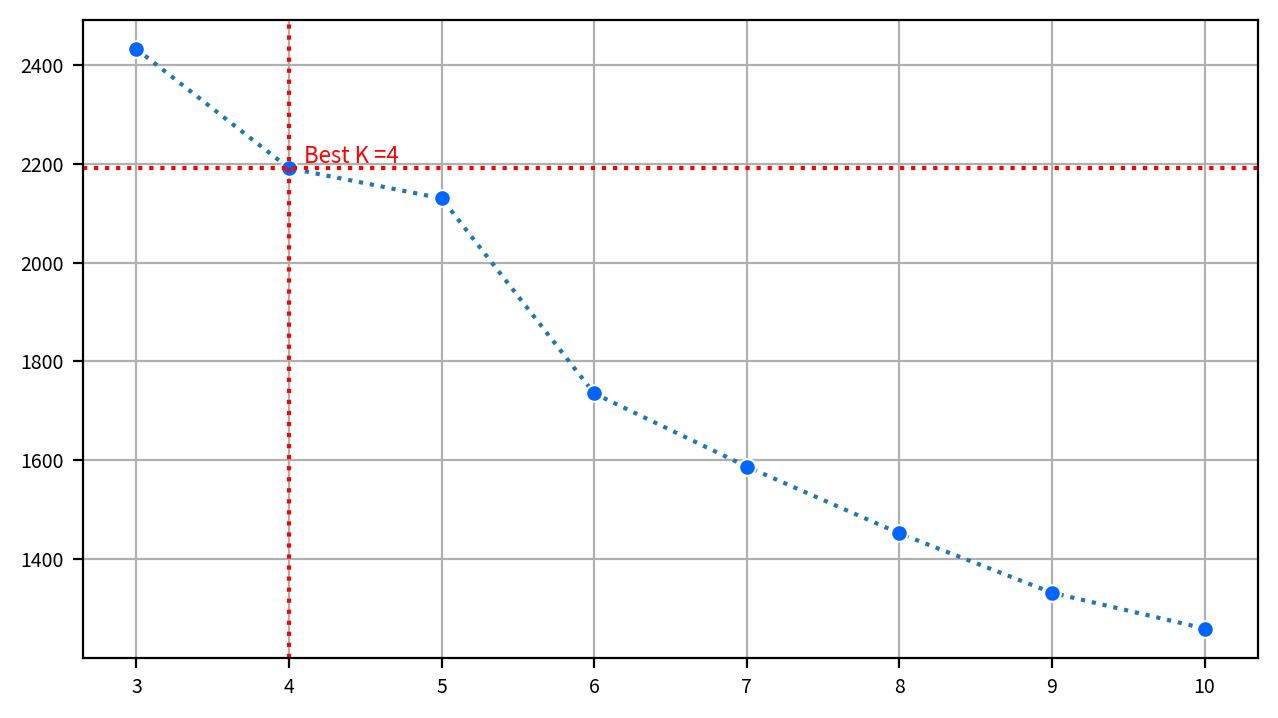

In [ ]:
# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Line Plot 그리기
sb.lineplot(x=klist, 
            y=inertia, 
            linestyle =':',
            marker ='o',
            markerfacecolor ='#0066ff' , 
            markeredgecolor='#ffffff')

#엘보우 포인트 표시
ax.axvline(x=best_k,color='red',linestyle=':')
ax.axhline(y=best_y,color='red',linestyle=':')
ax.text(
  best_k + 0.1,
   best_y + 0.1,
  'Best K =%d' % best_k,
  fontsize=8,
  ha='left',
  va='bottom',
  color='r'

)


# 3) 그래프 꾸미기
ax.grid(True)                 # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


#### [4] 엘보우 포인트 검증 - 실루엣 스코어 

- 관련 함수 정의

In [ ]:
def visualize_silhouette(estimator, X_features):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    sil_avg = silhouette_score(X=X_features, labels=estimator.labels_)
    sil_values = silhouette_samples(X=X_features, labels=estimator.labels_)

    y_lower = 10
    plt.suptitle(
        "Number of Cluster : " + str(estimator.n_clusters) + ", "
        "Silhouette Score :" + str(round(sil_avg, 3))
    )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_features) + (estimator.n_clusters + 1) * 10])
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.grid()

    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
    for i in range(estimator.n_clusters):
        ith_cluster_sil_values = sil_values[estimator.labels_ == i]
        ith_cluster_sil_values.sort()

        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / estimator.n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sil_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(estimator.labels_.astype(float) / estimator.n_clusters)
    ax2.scatter(
        X_features[X_features.columns[0]],
        X_features[X_features.columns[1]],
        marker="o",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = estimator.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="r",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.grid()

    plt.show()
    plt.close()

#### [6] 군집별 실루엣 스코어 확인

In [ ]:
#시작값은 최조 군집수
klist = list(range(3,11))
silhouette = []  #실루엣 스코어를 저장할 리스트

for k in klist:
  estimator = KMeans(n_clusters=k,random_state=52)
  estimator.fit(X=kmeans_df)
  cluster = estimator.predict(kmeans_df)
  s_score = silhouette_score(X=kmeans_df,labels=cluster)
  silhouette.append(s_score)


silhouette_df = DataFrame({'k':klist , 'silhouette_score' : silhouette})
silhouette_df

,k,silhouette_score
0,3,0.303467
1,4,0.216205
2,5,0.189686
3,6,0.226650
4,7,0.212894
5,8,0.212636
6,9,0.188334
7,10,0.188019


> 엘보우 포인트는 4로 도출되었지만, 실루엣 스코어 상으로는 k가 3일때 가장 높으므로
> 최적의 k 는 3으로 결정

#### [7] k=3 기준 군집 형성

In [ ]:
estimator = KMeans(n_clusters=3,random_state =52)
estimator.fit(X=kmeans_df)
clusters=estimator.predict(kmeans_df)


cdf = kmeans_df.copy()
cdf['ClusterID'] = clusters
cdf.head()

,PC1,PC2,PC3,PC4,ClusterID
0,1.112879,-0.548328,0.719904,1.209627,1
1,1.368329,0.047864,-0.204637,0.337011,1
2,1.646556,1.260658,-1.456981,1.703479,2
3,-1.131298,1.268001,-0.341819,-0.237528,0
4,0.669345,2.039832,-0.069120,1.069211,2


#### [8] 군집 결과 시각화

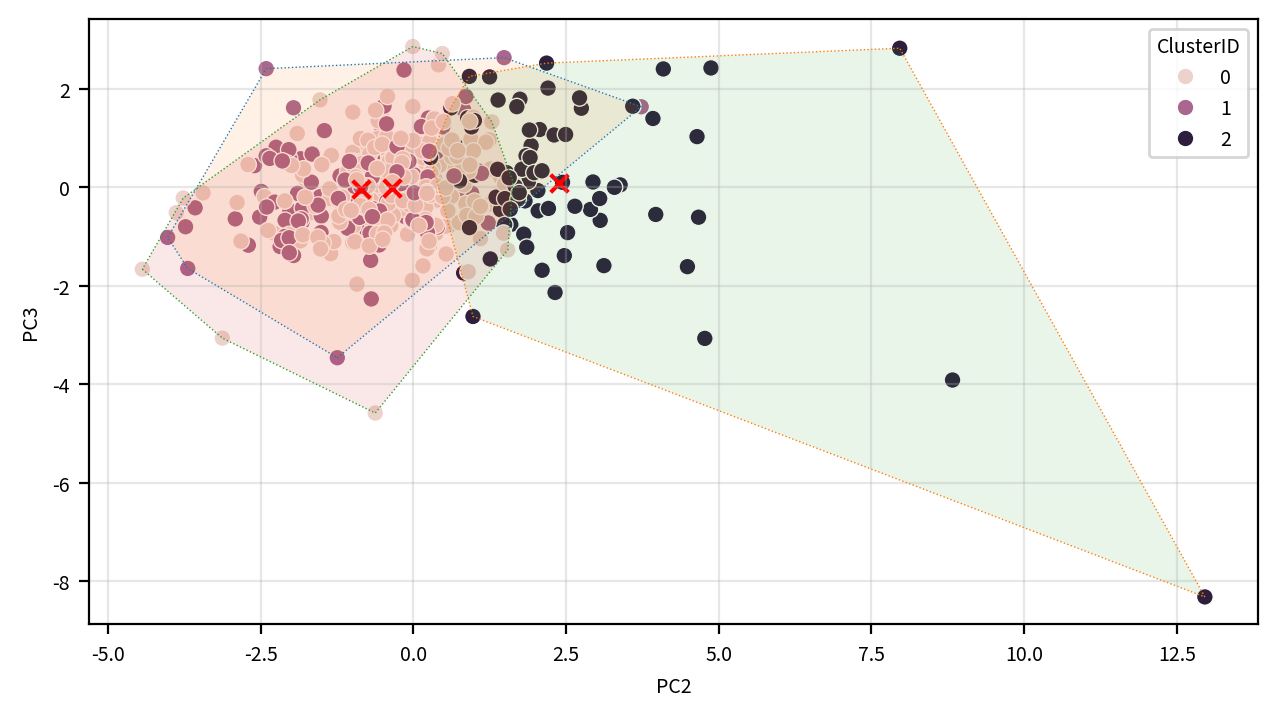

In [ ]:
vdf = cdf.copy()
hue_field ='ClusterID'
x_field =cdf.columns[1]    #연수입
y_field = cdf.columns[2] #지출점수

# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


#데이터 산점도
sb.scatterplot (data=vdf , x=x_field , y=y_field , hue=hue_field)



# 군집별 값의 종류별로 반복문 실행
for c in vdf[hue_field].unique():
  #값의 종류별로 데이터 프레임 구분
  df_c = vdf.loc[vdf[hue_field] == c , [x_field,y_field]]

  try:
    #외각선 좌표 계산
    hull = ConvexHull(df_c)

    #마지막 좌표 이후에 첫번쨰 좌표를 연결
    points = np.append(hull.vertices,hull.vertices[0])

    ax.plot( #type:ignore
      df_c.iloc[points,0] , df_c.iloc[points,1] , linewidth = 0.5 , linestyle =':'
      )
    
    ax.fill(df_c.iloc[points,0] , df_c.iloc[points ,1], alpha =0.1)


  except:
    pass

#군집별 중심점 표시
ax.scatter(
  estimator.cluster_centers_[:,1],   #연수입의 인덱스
  estimator.cluster_centers_[:,2],   #지출점수의 인덱스
  marker='x',
  c='red',
  alpha=1,
  s=40
)


ax.grid(True ,alpha =0.3) #배경 격자 표시
plt.tight_layout()
plt.show()
plt.close()

> 군집별 평균 구매 패턴을 어떻게 정리해보면 좋을까?

## 미션 5. 모든 고객을 꼭 묶어야 할까?

동일한 데이터에 DBSCAN을 적용하십시오.

min_samples와 eps 값을 데이터 기반으로 설정하고, 군집에 속하지 않는 고객(noise)을 확인하십시오.

이 고객들은 왜 다른 고객들과 묶이지 않았는지 구매 패턴 관점에서 간단히 추론해 봅시다.

📌 출제 의도

모든 고객을 군집에 포함시키는 것이 항상 좋은 선택은 아닙니다.
이 미션은 이상 고객도 중요한 분석 대상이 될 수 있음을 이해하기 위한 단계입니다.

In [ ]:
dbscan_df=pca_df.copy()

- min_samples 설정

In [ ]:
min_samples=3

- k 최근접 이웃을 통한 eps 도출

In [ ]:
# k = min_samples 설정
k=min_samples


#각 점에 대해 k 번쨰 최근접 이웃 거리 계산
neighbors = NearestNeighbors (n_neighbors=k)
neighbors_fit = neighbors.fit(dbscan_df)

#이떄 distance 는 각 데이터 포인트가 k 번째까지의 포인트와의 거리를 가까운 순서대로 리스트로 가지고 있음
distance ,indices = neighbors_fit.kneighbors(dbscan_df)


#모든 점의 거리 값을 가까운 순서대로 정렬 (오름차순)
s_distance = np.sort(distance,axis=0)


#각 데이터 포인트로부터의 거리 추출
target = s_distance[:,k-1]  #k 번째 이웃은 k-1 번쨰 이웃에 존재 , 즉 가장 멀리 있는 값을 가져와서 


#엘보우 포인트 찾기
kl= KneeLocator(range(0,len(target)),target,curve='convex',direction='increasing')
eps=kl.elbow_y

#결과값
print(f'eps:{eps}')


eps:1.8797476873312988


- eps 값을 기준으로 최적의 eps 구간 찾기
#### [1] eps 구간 잡기

In [ ]:
delta_ratio = 0.3
step_ratio=0.05

eps_min = eps*(1-delta_ratio)
eps_max=eps*(1+delta_ratio)
step=eps*step_ratio


eps_grid = np.arange(eps_min,eps_max+step,step)
eps_grid

array([1.31582338, 1.40981077, 1.50379815, 1.59778553, 1.69177292,
       1.7857603 , 1.87974769, 1.97373507, 2.06772246, 2.16170984,
       2.25569722, 2.34968461, 2.44367199, 2.53765938])

#### [2] eps 별 DBSCAN 결과 얻기

In [ ]:
labels_dict={}

for eps in eps_grid:
  estimator = DBSCAN(eps=eps,min_samples=min_samples)
  labels_dict[eps] = estimator.fit_predict(dbscan_df)


labels_dict

{np.float64(1.315823381131909): array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,
         0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1, -1, -1,  0,  0,  0,  0,  1, -1,  0, -1,  3,  0,  0,  0,  0,  0,
         0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
         0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1,  2,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  2,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0, -

## 미션 6. 우리가 고른 군집 수는 합리적이었을까?

Ward 방식의 계층적 군집 분석을 수행하고, 덴드로그램을 시각화하십시오.

이 덴드로그램을 기준으로 앞서 KMeans에서 선택한 군집 수가 구조적으로도 타당했는지 검토하십시오.

📌 출제 의도

계층적 군집은 새로운 답을 찾기 위한 도구가 아니라, 기존 선택을 점검하기 위한 시각적 근거를 제공하기 위한 단계입니다.

## 미션 7. “이제 고객을 사람으로 설명해 봅시다”

지금까지의 분석 결과를 종합하여 가장 적합하다고 판단한 군집 결과를 하나 선택하십시오.

선택한 군집을 바탕으로 고객 페르소나를 도출하고, 각 페르소나에 대해 다음 내용을 정리하십시오.

주요 구매 카테고리

구매 행동의 특징

사업적 관점에서의 의미

관리 또는 대응 전략

📌 출제 의도

군집 분석의 최종 목적은 숫자나 그래프가 아니라 의사결정에 도움이 되는 설명입니다.
이 미션은 분석 결과를 사람의 언어로 바꾸는 연습입니다.

## 미션 8. “이번 분석의 한계는 무엇일까?”

지금까지 수행한 모든 분석 과정을 되돌아보며, 본 프로젝트가 가지는 한계점을 생각해 봅시다.

한계점은 단순한 반성이 아니라,
**“이 데이터와 방법으로는 어디까지 말할 수 있고, 어디부터는 말할 수 없는가”**를 구분하는 과정입니다.

다음과 같은 관점 중 일부를 참고하여 서술해 보십시오.
(아래 항목을 모두 다룰 필요는 없으며, 최소 1가지 이상 명확히 제시하면 됩니다.)

구매 금액이라는 정적 데이터만 사용했을 때의 한계

거래 시점, 계절성 등 시간 정보가 없다는 점의 영향

고객의 실제 업종·규모·의사결정 맥락을 알 수 없다는 점

군집 결과가 분석자의 전처리·알고리즘 선택에 의존한다는 점

군집이 “정답”이 아니라 “해석 가능한 가설”에 가깝다는 점

한계를 제시할 때에는, 단순히 “데이터가 부족하다”고 쓰기보다
그 부족함이 해석에 어떤 영향을 주는지를 문장으로 서술해 주시기 바랍니다.

📌 출제 의도

이 미션의 목적은 분석 결과를 깎아내리는 것이 아니라, 분석이 허용하는 주장과 허용하지 않는 주장을 구분하는 연구적 태도를 기르는 데 있습니다.
좋은 분석은 결론뿐 아니라, 결론이 어디까지 유효한지도 함께 말할 수 있어야 합니다.